# 1. IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 2. IMPORTING DATA

In [2]:
df = pd.read_csv("employee_data.csv")

# 3. INSPECTING DATA

In [3]:
df.head()

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,38,NaN,Travel_Frequently,1444,Human Resources,1,4,Other,1,...,2,80,1,7,2,3,6,2,1,2
1,2,37,1.0,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,1,80,0,15,2,1,1,0,0,0
2,3,51,1.0,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,80,3,18,2,4,10,0,2,7
3,4,42,0.0,Travel_Frequently,555,Sales,26,3,Marketing,1,...,4,80,1,23,2,4,20,4,4,8
4,5,40,NaN,Travel_Rarely,1194,Research & Development,2,4,Medical,1,...,2,80,3,20,2,3,5,3,0,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int64  
 14  JobLevel

In [5]:
#Mengetahui kolom dengan nilai null values
df.isnull().sum()

,0
EmployeeId,0
Age,0
Attrition,412
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0


Distribusi Kelas Attrition (%):
Attrition
0.0    83.081285
1.0    16.918715
Name: proportion, dtype: float64


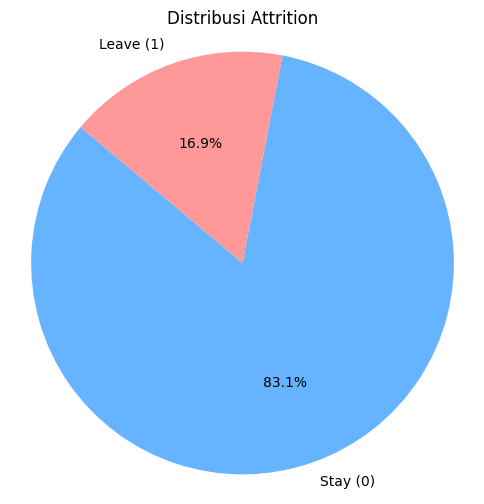

In [6]:
# Hitung distribusi kelas
attrition_counts = df["Attrition"].value_counts(normalize=True) * 100

# Cetak persentase
print("Distribusi Kelas Attrition (%):")
print(attrition_counts)

# Visualisasi pie chart
labels = ['Stay (0)', 'Leave (1)']
colors = ['#66b3ff','#ff9999']

plt.figure(figsize=(6,6))
plt.pie(attrition_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribusi Attrition')
plt.axis('equal')  # Circle
plt.show()

Datasetnya imbalance karena jumlah pegawai yang stay lebih banyak dari pegawai yang leave.

# 4. CLEANSING DATA

In [7]:
# Hapus baris yang memiliki nilai kosong di kolom Attrition
df = df[df["Attrition"].notnull()]

In [8]:
# Hapus duplikat jika ada
df = df.drop_duplicates()

In [9]:
# Mengubah nilai Attrition dari 0/1 menjadi Stay/Leave (untuk interpretasi manual, tapi model tetap pakai 0/1)
df['Attrition'] = df['Attrition'].astype(int)

# 5. FEATURE ENGINEERING

In [10]:
# Encode kolom kategorikal menggunakan LabelEncoder
le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [11]:
# Kolom seperti 'EmployeeCount', 'EmployeeNumber', dan 'Over18' tidak relevan, bisa dihapus
cols_to_drop = ['EmployeeId', 'EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

In [12]:
# Pisahkan fitur dan target
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

In [13]:
# SPLIT DATA TRAIN & TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# APPLY SMOTE buat bikin datanya balance dengan oversampling minority class
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


# 6. TRAIN MODEL DENGAN DATA YANG SUDAH DIRESAMPLE

In [14]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

# 7. EVALUASI MODEL

In [15]:
y_pred = model.predict(X_test)

In [16]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[164  12]
 [ 22  14]]


In [17]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91       176
           1       0.54      0.39      0.45        36

    accuracy                           0.84       212
   macro avg       0.71      0.66      0.68       212
weighted avg       0.82      0.84      0.83       212



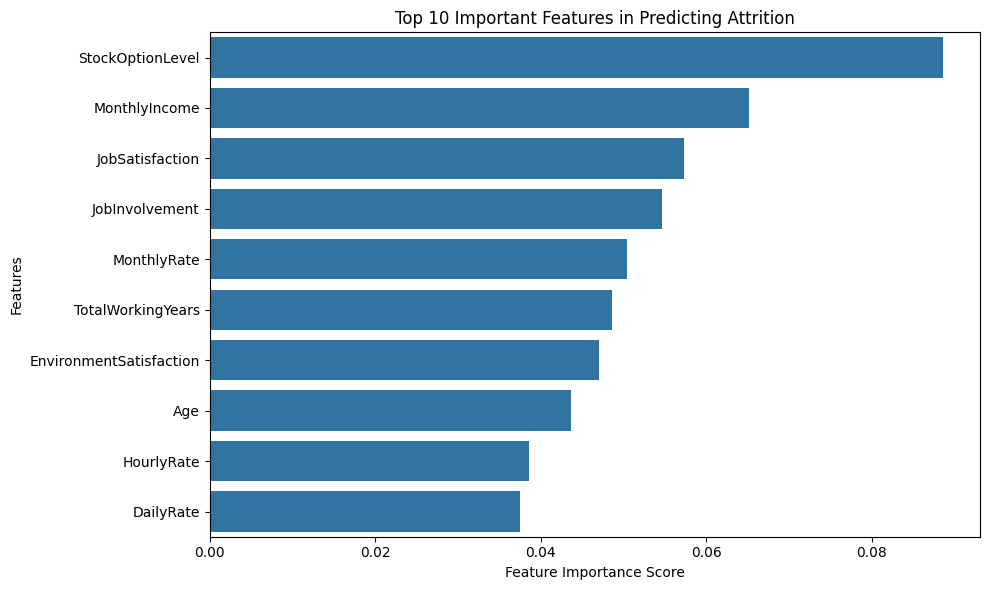

In [18]:
# Visualisasi feature importance
importances = model.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features in Predicting Attrition")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [19]:
# Simpan model ke file
joblib.dump(model, 'attrition_model.pkl')

['attrition_model.pkl']

In [20]:
!pip freeze > requirements.txt